## Task statement
We asked to prepare a prototype of machine learning model for Zifra. The company develops efficiency solutions for heavy industry. The project and datasets was provided by Zifra to Yandex.Practicum. 
<br><br>
The model should predict the amount of gold recovered from gold ore. We are provided with data on extraction and purification. We asked to:
- Prepare the data;
- Perform data analysis;
- Develop and train a model
<br><br>
To evaluate the model should be used sMAPE metric: <br>
$sMAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{|y_{i} - \hat{y}_{i}|}{(|y_{i}| + |\hat{y}_{i}|)/2}*100\%$<br>
Both rougher stage output and final stage output should be taking into account:<br><br>
$Final\space sMAPE = 25\%*sMAPE(rougher) + 75\%*sMAPE(final)$


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
import itertools
import gc
from tqdm import tqdm_notebook as tqdm
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import  mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
#define constants and set random seeds
TARGET = ['rougher.output.recovery', 'final.output.recovery']
DATE_TARGET = ['date'] + TARGET
PATH = '/datasets/'

rng = np.random.RandomState(1234)
np.random.seed(1234)

## Load the data

In [3]:
!ls /datasets/gold_*

/datasets/gold_recovery_full.csv  /datasets/gold_recovery_train.csv
/datasets/gold_recovery_test.csv


In [4]:
data_train = pd.read_csv(PATH + 'gold_recovery_train.csv')
data_test = pd.read_csv(PATH + 'gold_recovery_test.csv')
data_full = pd.read_csv(PATH + 'gold_recovery_full.csv')

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [6]:
data_test.shape

(5856, 53)

shapes of train and test sets differ. Let's see what extra columns are there in the train set

In [7]:
[col for col in data_train.columns if col not in data_test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

The test set lacks all the output and calculated features.

In [8]:
data_full.shape

(22716, 87)

The full data has the missing features for the test set so we'll use them for model evaluation at the end of the project. For now we'll do the data preprocessing, then we'll build the models based on the training set, predict the targets for the test set and finally evaluate our model performance with the help of full data set.

## Data preprocessing

We have some calculated features - let's check if the values actually corresponds to calculations

In [9]:
def calculate_recovery(C, F, T):
    """
    C - series of output.concentrate_au (Concentrate)
    F - series of input.feed_au (Feed)
    T - output.tail_au (Tail)
    """
    result = C * (F - T)/(F * (C-T))*100
    # from the formula given and the technological process we understand that the value should be in range (0,100). 
    # Anything else is obviously error in the data and we return it as NaN
    result = result.apply(lambda x: np.nan if x <= 0 or x >= 100 else x)
    return result

In [10]:
recovery_data = data_train[['rougher.output.recovery']]
recovery_data['rougher.output.recovery.calculated'] = calculate_recovery(data_train['rougher.output.concentrate_au']
                                                                         , data_train['rougher.input.feed_au']
                                                                         , data_train['rougher.output.tail_au'])
recovery_data.head()

,rougher.output.recovery,rougher.output.recovery.calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [11]:
recovery_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 2 columns):
rougher.output.recovery               14287 non-null float64
rougher.output.recovery.calculated    13961 non-null float64
dtypes: float64(2)
memory usage: 263.6 KB


In [12]:
recovery_data = recovery_data.dropna()

In [13]:
mean_absolute_error(recovery_data['rougher.output.recovery'], recovery_data['rougher.output.recovery.calculated'])

9.665437357510252e-15

The values indeed corresponds to calculated ones perfectly we'll use it for restoring some missing values. Let's check if the full data table contains the same targets as train data. Just in case...

In [14]:
# We'll use date as a primery key for our tables
data_train.date = pd.to_datetime(data_train.date)
data_test.date = pd.to_datetime(data_test.date)
data_full.date = pd.to_datetime(data_full.date)

In [15]:
train_targets = data_train[DATE_TARGET]

In [16]:
train_targets = train_targets.merge(data_full[DATE_TARGET], how='left', on='date')
train_targets.head()

,date,rougher.output.recovery_x,final.output.recovery_x,rougher.output.recovery_y,final.output.recovery_y
0,2016-01-15 00:00:00,87.107763,70.541216,87.107763,70.541216
1,2016-01-15 01:00:00,86.843261,69.266198,86.843261,69.266198
2,2016-01-15 02:00:00,86.842308,68.116445,86.842308,68.116445
3,2016-01-15 03:00:00,87.226430,68.347543,87.226430,68.347543
4,2016-01-15 04:00:00,86.688794,66.927016,86.688794,66.927016


In [17]:
train_targets = train_targets.dropna()
mean_absolute_error(train_targets['rougher.output.recovery_x'], train_targets['rougher.output.recovery_y'])

2.0589619171788894e-17

In [18]:
mean_absolute_error(train_targets['final.output.recovery_x'], train_targets['final.output.recovery_y'])

7.909426876967686e-18

Ok. They are the same. We will use the full data mostly in preprocessing stage. Let's try and recover some missing rougher recovery data

In [19]:
data_full['rougher.output.recovery.calculated'] = calculate_recovery(data_full['rougher.output.concentrate_au']
                                                                     , data_full['rougher.input.feed_au']
                                                                     , data_full['rougher.output.tail_au']
                                                                    )

In [20]:
data_full[data_full['rougher.output.recovery'].isna()].shape

(3119, 88)

In [21]:
data_full[data_full['rougher.output.recovery'].isna()]['rougher.output.recovery.calculated'].dropna().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: rougher.output.recovery.calculated, dtype: float64

Unfortunately it turns out we can't recover any missing values in the targets

In [22]:
data_full[data_full['final.output.recovery'].isna()].shape

(1963, 88)

Now let's take a look at the input variables

In [23]:
train_features = data_train[[col for col in data_test.columns]]
train_features['test_set'] = False
data_test['test_set'] = True
features = pd.concat([train_features, data_test])
features.shape

(22716, 54)

In [24]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22716 entries, 0 to 5855
Data columns (total 54 columns):
date                                          22716 non-null datetime64[ns]
primary_cleaner.input.sulfate                 21107 non-null float64
primary_cleaner.input.depressant              21170 non-null float64
primary_cleaner.input.feed_size               22716 non-null float64
primary_cleaner.input.xanthate                21565 non-null float64
primary_cleaner.state.floatbank8_a_air        22660 non-null float64
primary_cleaner.state.floatbank8_a_level      22667 non-null float64
primary_cleaner.state.floatbank8_b_air        22660 non-null float64
primary_cleaner.state.floatbank8_b_level      22673 non-null float64
primary_cleaner.state.floatbank8_c_air        22662 non-null float64
primary_cleaner.state.floatbank8_c_level      22673 non-null float64
primary_cleaner.state.floatbank8_d_air        22661 non-null float64
primary_cleaner.state.floatbank8_d_level      22673 non-n

We've got the information that close in time data points should be close in results, at least parameter values should be close. So we sort by datetime: 

In [25]:
features.sort_values(by='date', inplace=True)
features.reset_index()
features.date.describe()

count                   22716
unique                  22716
top       2017-10-18 12:59:59
freq                        1
first     2016-01-15 00:00:00
last      2018-08-18 10:59:59
Name: date, dtype: object

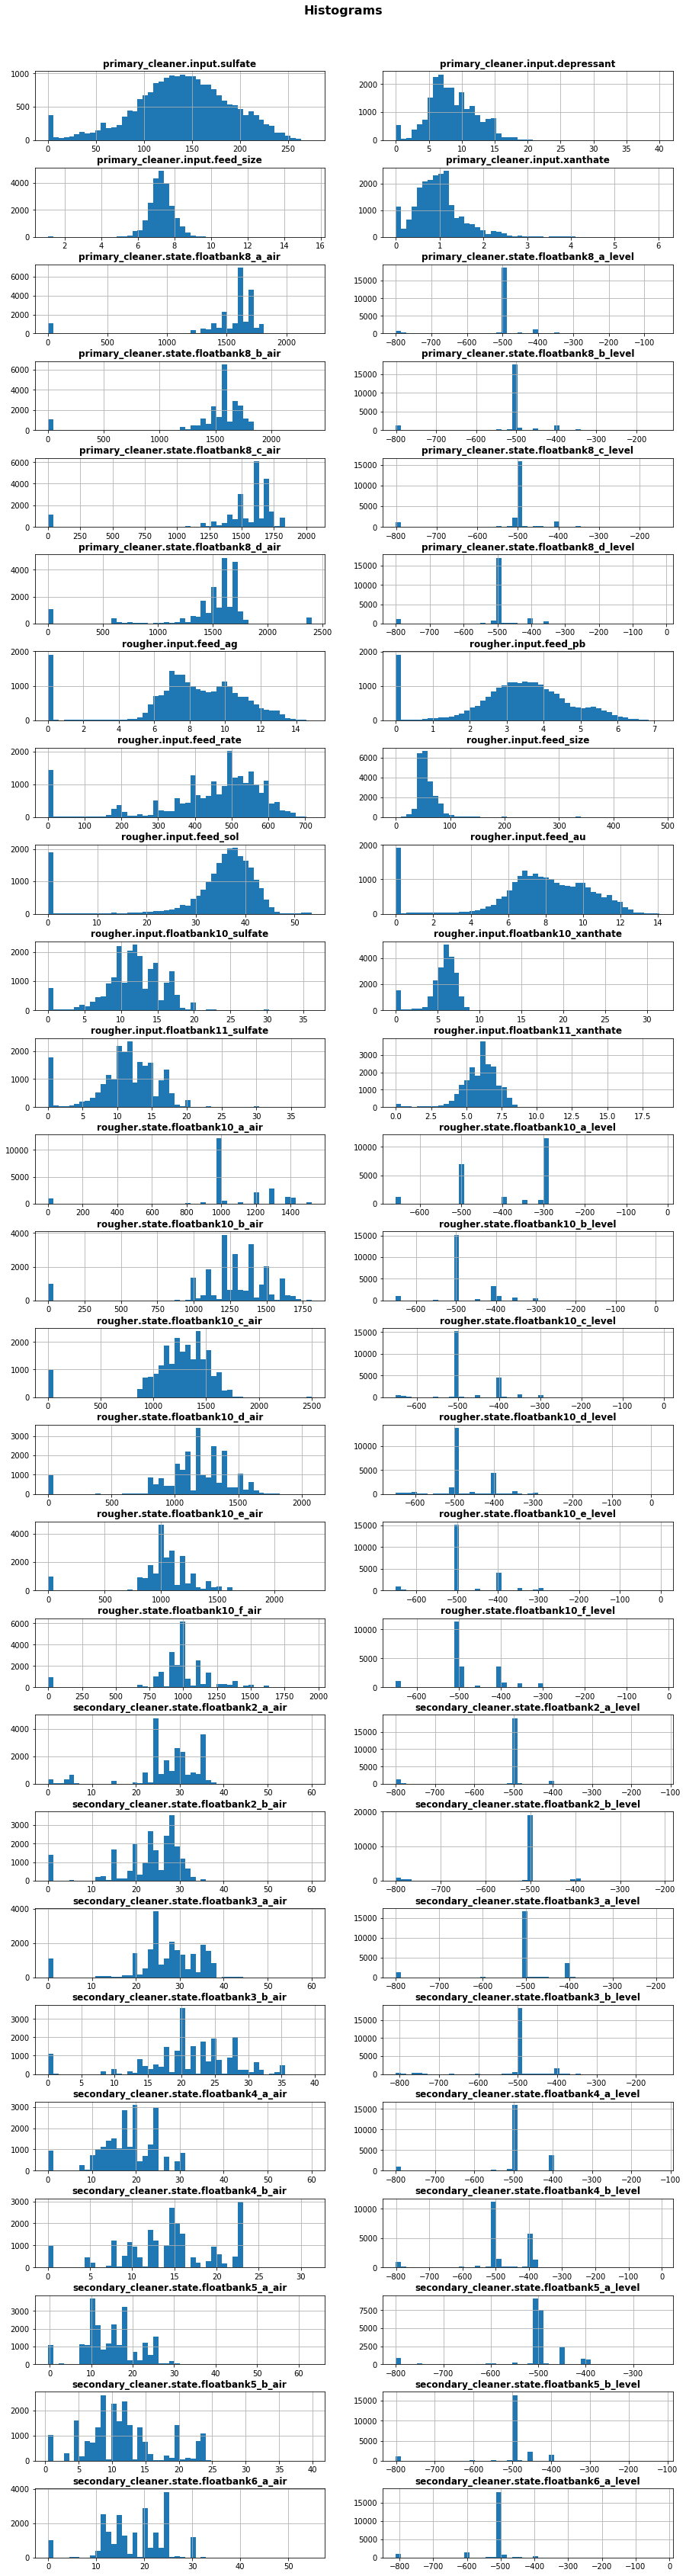

In [26]:
col_for_hist = features.columns[1:-1]
fig, axes = plt.subplots(26,2, figsize=(15,60))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, col in enumerate(col_for_hist):
    features[col].hist(bins=50, ax=axes[i//2,i%2])
    #features[features['test_set']][col].hist(bins=50, ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(col, fontweight='bold', size=12)
    
plt.suptitle('Histograms', fontweight='bold', size=16, y=0.90)
plt.show()

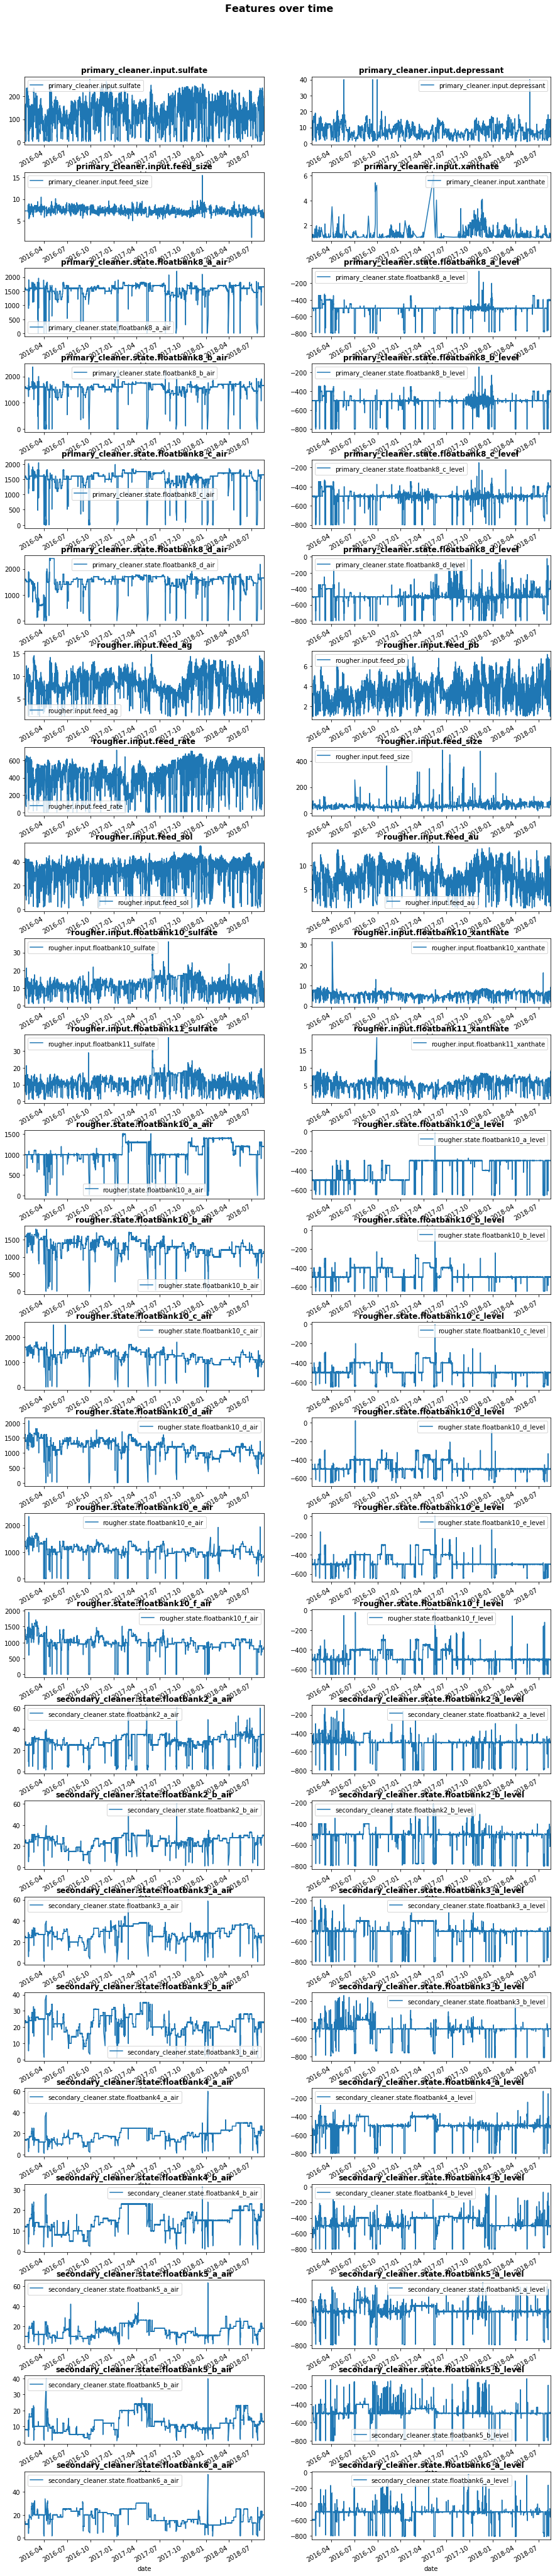

In [27]:
col_for_hist = features.columns[1:-1]
fig, axes = plt.subplots(26,2, figsize=(15,80))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, col in enumerate(col_for_hist):
    features[abs(features[col]) > 1].plot(x='date', y=col, ax=axes[i//2,i%2])
    axes[i//2,i%2].set_title(col, fontweight='bold', size=12)
    
plt.suptitle('Features over time', fontweight='bold', size=16, y=0.90)
plt.show()

On the histograms we may see a lot of zero or close to zero values that doesn't look right for the parameter distributions. We suspect two possibilities - error in the dataset provided or some technological thing like some service works or just lack of the raw materials due to logistic problems. We could check it with the source of the data set but for now we'll deal with it like with outliers. <br><br>
Our features have a lot of missing values both in training set and the test set. We still want to be able to predict the outcome for the test data points and this prevent us from simply deleting the data with missing values. All features have at least 80% of values in place and most of them have more then 95% of meaningful values. We can't really confirm from the graphs above that the missing values tends to be close for close in time mesurements but the data description contains this claim: "Parameters that are next to each other in terms of time are often similar." Thus we'll fill the missing values based on it.

In [28]:
features = features.interpolate()

In [29]:
# we could have missing values left due to the method chosen but luckily we don't
features.isna().any().any()

False

Next we need target variable. We should predict two variables: rougher.output.recovery and final.output.recovery. All the other calculated and intermediate features are of no interest for us at the moment. Let's set up targets:

In [30]:
targets = data_full[DATE_TARGET]
targets.shape

(22716, 3)

In [31]:
targets.isna().any()

date                       False
rougher.output.recovery     True
final.output.recovery       True
dtype: bool

We have some missing targets - it's no good neither for train nor for test sets. 

In [32]:
features_with_target = features.merge(targets, how='left', on='date')
features_with_target.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,test_set,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,False,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,False,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,False,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,False,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,False,86.688794,66.927016


In [33]:
features_with_target.shape

(22716, 56)

In [34]:
features_with_target.dropna(inplace=True)
features_with_target.shape

(19439, 56)

## Data Exploration

In [35]:
def plot_dynamic_histograms(data, metal):
    """
    function plot histograms of the concentration of metal on different stages of purification process
    data - pandas DataFrame 
    metal - marker for metal: ['au', 'ag', 'pb', 'sol']
    """
    first_col = ['rougher.input.feed_' + metal, 'rougher.output.concentrate_' + metal
             , 'primary_cleaner.output.concentrate_' + metal, 'pass', 'final.output.concentrate_' + metal]
    second_col = ['pass', 'rougher.output.tail_' + metal, 'primary_cleaner.output.tail_' + metal
              , 'secondary_cleaner.output.tail_' + metal, 'final.output.tail_' + metal]
    
    fig, axes = plt.subplots(5,2, figsize=(12,20))
    fig.subplots_adjust(wspace=.2, hspace=.4)
    x_max = data[first_col[4]].max() + 1
    for i in range(5):
        if first_col[i] != 'pass':
            data[first_col[i]].hist(bins=50, ax=axes[i,0])
            axes[i,0].set_title(first_col[i], fontweight='bold', size=12)
            axes[i,0].set_xlim([-1,x_max])
        if second_col[i] != 'pass':
            data[second_col[i]].hist(bins=50, ax=axes[i,1])
            axes[i,1].set_title(second_col[i], fontweight='bold', size=12)
    plt.suptitle(f'Histograms of {metal} concentrations on different stages', fontweight='bold', size=16, y=0.92)
    plt.show()

In [36]:
# Set up data to look at
data = data_train[data_train['date'].isin(features_with_target[~features_with_target['test_set']].date)]

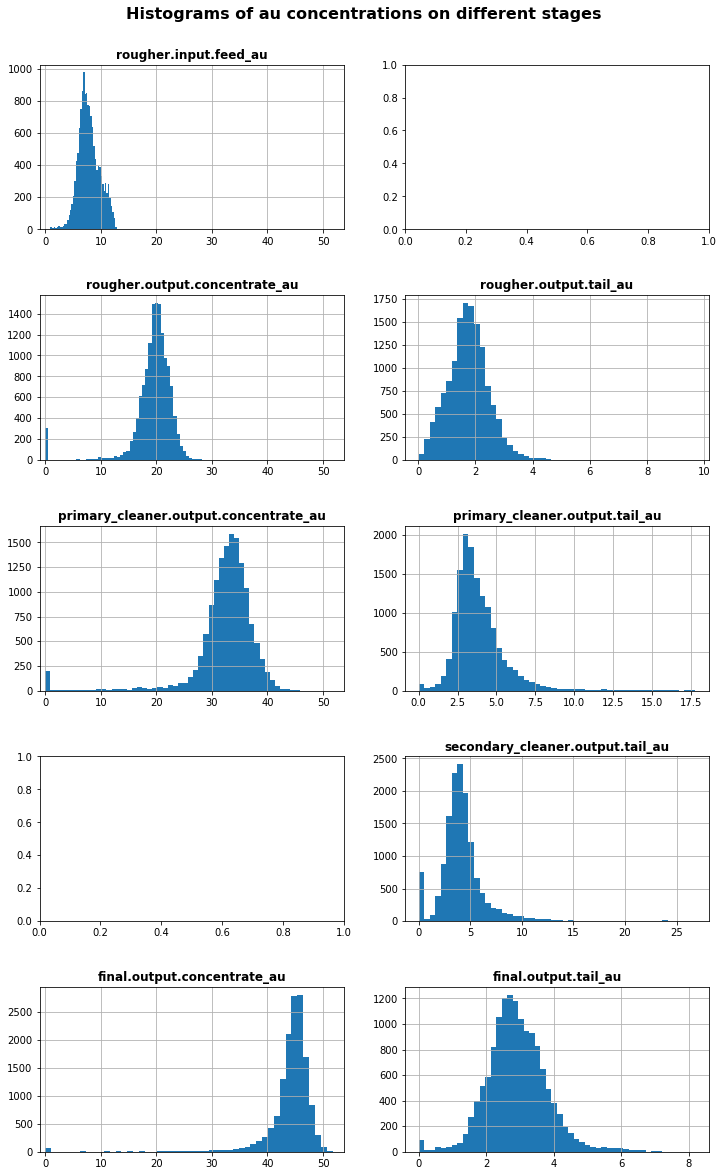

In [37]:
plot_dynamic_histograms(data, 'au')

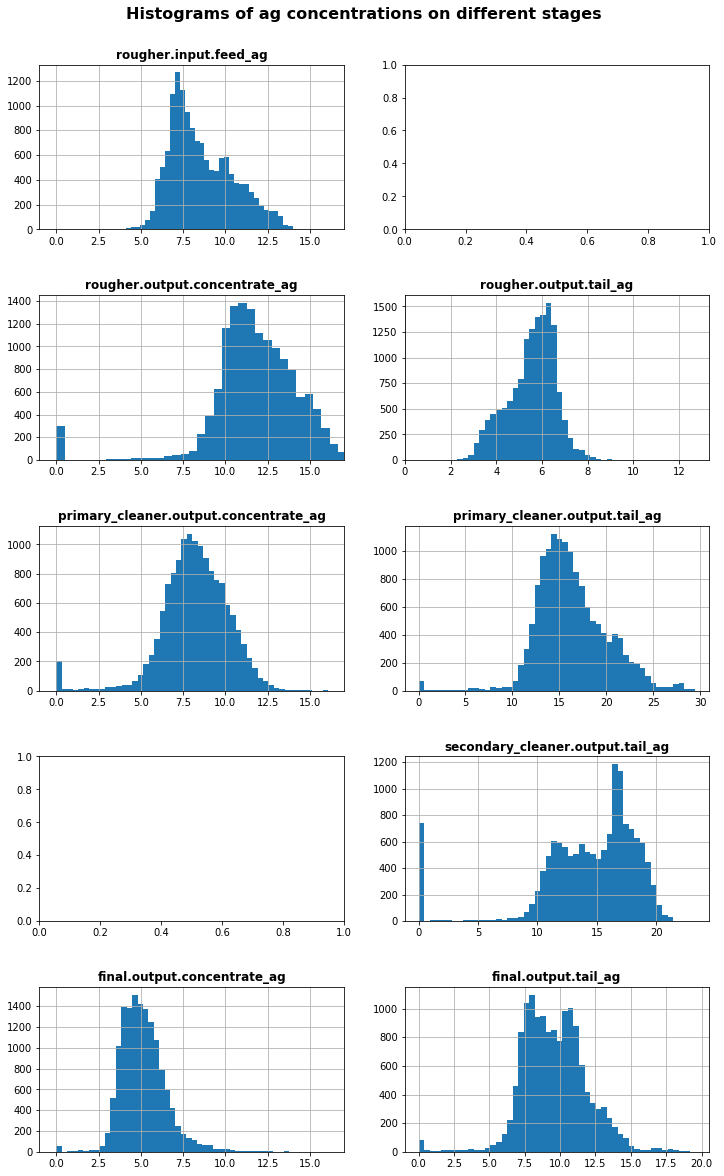

In [38]:
plot_dynamic_histograms(data, 'ag')

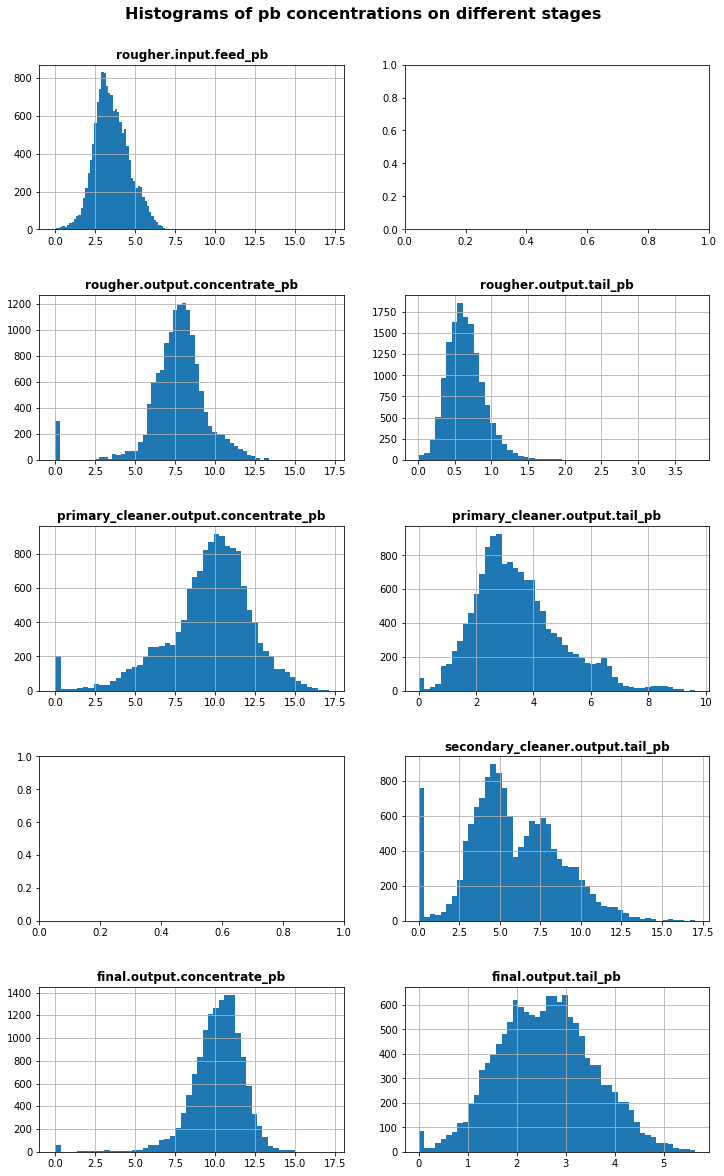

In [39]:
plot_dynamic_histograms(data, 'pb')

In [40]:
#plot_dynamic_histograms(data, 'sol')

We may see that there are some error values close to zero for metal output after rougher stage. Obviously this is mistake because there is almost no such strangeness for the final output and really how come the zero concentration with non zero tail concentration! Let's see what we have for rougher recovery for these points, which is important for us.

In [41]:
data_tmp = data[data['rougher.output.concentrate_au'] < 1]
data_tmp.shape

(303, 87)

In [42]:
data_tmp = data[data['rougher.output.concentrate_au'] == 0]
data_tmp.shape

(297, 87)

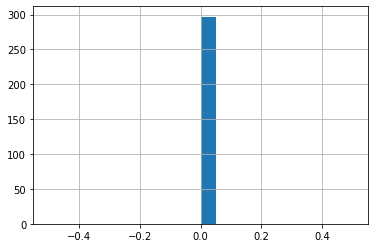

In [43]:
data_tmp['rougher.output.recovery'].hist(bins=20)

this is no good data - we don't need it for training our models. Actually we don't need such data in the test set also, this is an error in the data set and we can't really evaluate our models based on such data points. So we update our data set

In [44]:
features_with_target.shape

(19439, 56)

In [45]:
features_with_target[features_with_target['rougher.output.recovery'] < 1].shape

(394, 56)

In [46]:
features_with_target.drop(features_with_target[features_with_target['rougher.output.recovery'] < 1].index, inplace=True)
features_with_target.shape

(19045, 56)

In [47]:
features_with_target[features_with_target['final.output.recovery'] < 1].shape

(99, 56)

Really the same logic applied to the final recovery - we don't need zero-target data neither for training models nor for testing it.

In [48]:
features_with_target.drop(features_with_target[features_with_target['final.output.recovery'] < 1].index, inplace=True)
features_with_target.shape

(18946, 56)

Just to mention it - after removing some extreem data points we still have a bunch of outliers in our data. Not zeroes but unusually low values...

In [49]:
X_train = (features_with_target
           .loc[~features_with_target['test_set']]
           .drop(DATE_TARGET + ['test_set'], axis=1))
Y_train = (features_with_target
           .loc[~features_with_target['test_set']]
           .loc[:, TARGET])
X_test = (features_with_target
           .loc[features_with_target['test_set']]
           .drop(DATE_TARGET + ['test_set'], axis=1))
Y_test = (features_with_target
           .loc[features_with_target['test_set']]
           .loc[:, TARGET])

In [50]:
X_train.shape, Y_train.shape

((13792, 52), (13792, 2))

In [51]:
X_test.shape, Y_test.shape

((5154, 52), (5154, 2))

In [52]:
data_test[[col for col in data_test.columns if col not in X_train.columns]].columns

Index(['date', 'test_set'], dtype='object')

All the features are in place. We don't need date - it's an unique key for us

Let's take a look at how input variables distributed in train and test sets

In [53]:
input_data_train = X_train[[col for col in X_train.columns if 'rougher.input.feed' in col]]
input_data_test = X_test[[col for col in X_test.columns if 'rougher.input.feed' in col]]
input_data_train.shape, input_data_test.shape

((13792, 6), (5154, 6))

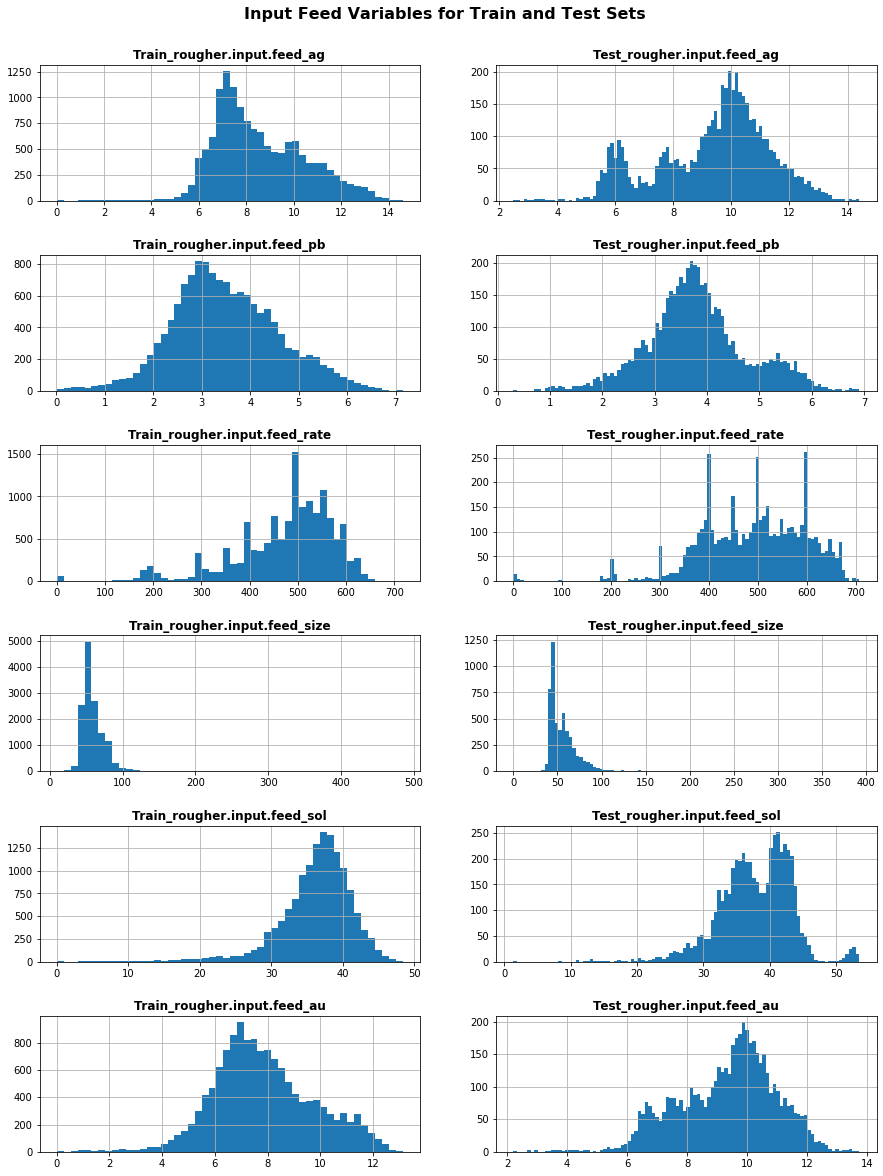

In [54]:
fig, axes = plt.subplots(6,2, figsize=(15,20))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, col in enumerate(input_data_train.columns):
    input_data_train[col].hist(bins=50, ax=axes[i,0])
    axes[i,0].set_title('Train_' + col, fontweight='bold', size=12)
    input_data_test[col].hist(bins=100, ax=axes[i,1])
    axes[i,1].set_title('Test_' + col, fontweight='bold', size=12)
    
plt.suptitle('Input Feed Variables for Train and Test Sets', fontweight='bold', size=16, y=0.92)
plt.show()

We can see that there is very significant difference in distributions of the concentrations of metals in input feeds between the train set and the test set provided. Taking into account the fact that the sizes are big enough we may conclude that the test set provided wasn't chosen randomly. Hence we can't expect that evaluation with the test set of our models trained on the train set would be correct. 

The main goal of this work is to provide the accurate model for prediction of the recovery rates based on the input variables. To test our model correctly we can't proceed with the train and test sets provided. We have all needed information in the full data set and we cleaned it already in the dataframe features_with_targets so we just split it into train and test set in a proper manner:

In [55]:
X = features_with_target.drop(DATE_TARGET + ['test_set'], axis=1)
Y = features_with_target.loc[:, TARGET]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1234, test_size=0.25)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((14209, 52), (4737, 52), (14209, 2), (4737, 2))

Let's see how the input variable distributed in our new split

In [56]:
input_data_train = X_train[[col for col in X_train.columns if 'rougher.input.feed' in col]]
input_data_test = X_test[[col for col in X_test.columns if 'rougher.input.feed' in col]]
input_data_train.shape, input_data_test.shape

((14209, 6), (4737, 6))

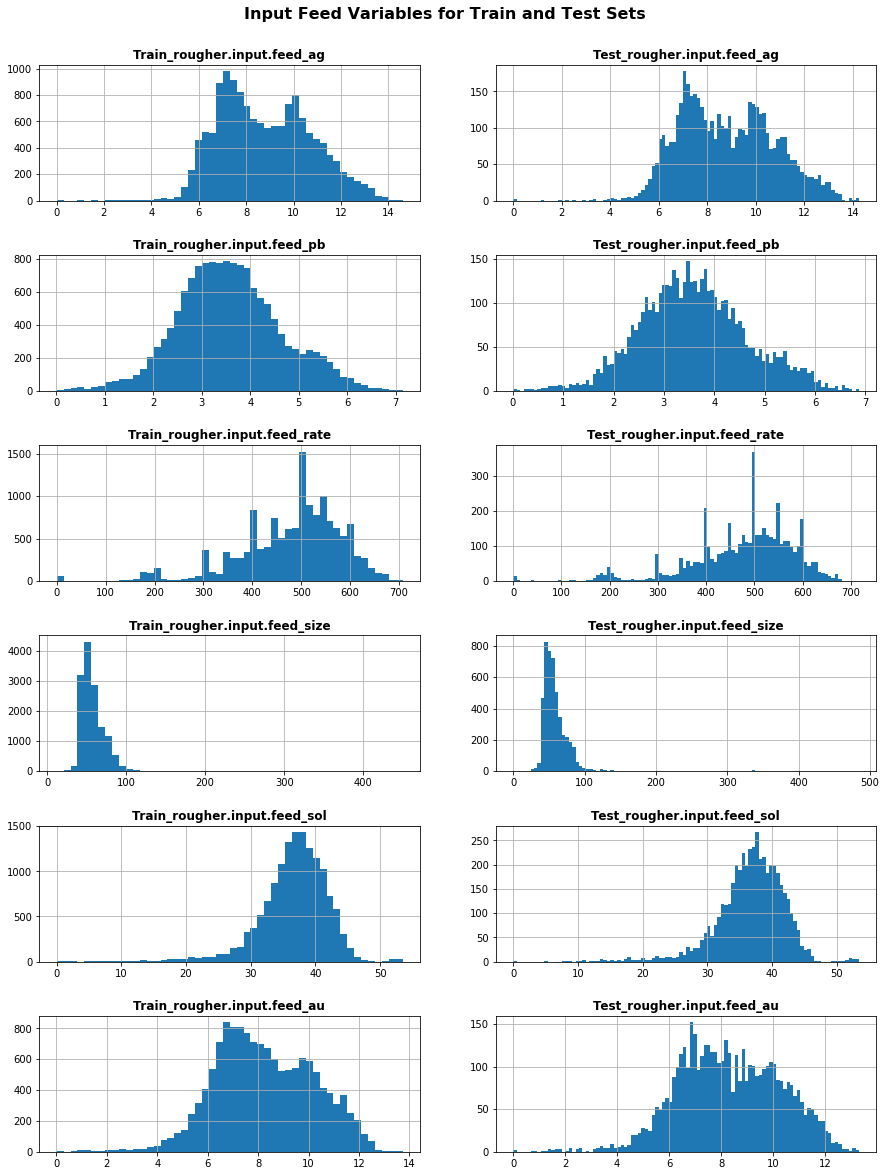

In [57]:
fig, axes = plt.subplots(6,2, figsize=(15,20))
fig.subplots_adjust(wspace=.2, hspace=.4)
for i, col in enumerate(input_data_train.columns):
    input_data_train[col].hist(bins=50, ax=axes[i,0])
    axes[i,0].set_title('Train_' + col, fontweight='bold', size=12)
    input_data_test[col].hist(bins=100, ax=axes[i,1])
    axes[i,1].set_title('Test_' + col, fontweight='bold', size=12)
    
plt.suptitle('Input Feed Variables for Train and Test Sets', fontweight='bold', size=16, y=0.92)
plt.show()

Now the shapes are close just like it should be expected from the  random split of a large sample.

## Selecting the model

### Metric

First let's define the custom loss function according with the business demands

In [58]:
# one-dimentional sMAPE
def sMAPE_1d(y_true, y_predict):
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    return (np.abs(y_true - y_predict)*2/(np.abs(y_true) +np.abs(y_predict))).mean()*100

In [59]:
#final sMAPE
def final_sMAPE(y_true, y_predict):
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    return 0.25 * sMAPE_1d(y_true[:,0], y_predict[:,0]) + 0.75 * sMAPE_1d(y_true[:,1], y_predict[:,1])

Luckily we already removed zero and close to zero values of y_true, thus we won't have problems with this metric for our dataset

In [60]:
# Custom scorer - we need it for grid search
mape_scorer = make_scorer(final_sMAPE, greater_is_better=False)

### Sanity check

In [61]:
Y_pred = Y_test.copy()
Y_pred['rougher.output.recovery'] = Y_train['rougher.output.recovery'].mean()
Y_pred['final.output.recovery'] = Y_train['final.output.recovery'].mean()

In [62]:
final_sMAPE(Y_test, Y_pred)

8.815427780464011

Now we have the upper bound for our models perfomances

### Grid Search

Let's check some standard regressors from sklearn library. If the regressor daesn't work with multidimentional target we'll use MultiOutputRegressor wrapper.

In [63]:
def perform_Grid_Search(X, Y, regressors, parameters):
    """
    This is just helper function that performs grid search for dictionary of regressors and parameters for them
    The keys in regressors and parameters should be the same
    X - independent variables
    Y - dependent variables
    """
    for name in tqdm(regressors.keys()):
        search = GridSearchCV(regressors[name], parameters[name], scoring=mape_scorer, n_jobs=-1
                            , cv=5, verbose=1, return_train_score=True)
        search.fit(X,Y)
        std = pd.DataFrame(search.cv_results_).loc[search.best_index_, 'std_test_score']
        print('Best params for ', name)
        print(search.best_params_)
        print('Best score for {}: {:.4f} ({:.4f})'.format(name, search.best_score_, std))

In [64]:
regressors ={
    'ridge': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Ridge())
    ]),
    'lasso' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', Lasso())
    ]),
    'enet' : Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', ElasticNet())
    ]),
    'random_forest' : RandomForestRegressor(random_state=rng),
    'gboost' : MultiOutputRegressor(GradientBoostingRegressor(max_features='sqrt', random_state=rng)),
    'ada_boost' : MultiOutputRegressor(AdaBoostRegressor(random_state=rng))
}

In [65]:
parameters ={
    'ridge' : {
        'regressor__alpha' : [0.1, 1, 10, 100]
    },
    'lasso' : {
        'regressor__alpha' : [10**(-x) for x in range(-1,4)],
        'regressor__max_iter' : [1000]
    },
    'enet' : {
        'regressor__alpha' : [10**(-x) for x in range(3,5)],
        'regressor__max_iter' : [1000],
        'regressor__l1_ratio' : [0.3, 0.5, 0.7]
    },
    'random_forest' : {
        'n_estimators' : [100, 300],
        'max_depth' : range(10,21,5),
        'min_impurity_decrease' : [0, 0.0001]
    },
    'gboost' : {
        'estimator__loss': ['huber'],
        'estimator__n_estimators' : [100, 300],
        'estimator__learning_rate' : [0.001, 0.01],
        'estimator__max_depth' : range(10,21,5),
        'estimator__min_impurity_decrease' : [0.0001, 0.001]
    },
    'ada_boost' : {
        'estimator__n_estimators' : [100, 500],
        'estimator__learning_rate' : [0.1, 1]
    }
}

Such a grid searches could be quite costly in terms of computational time. Thus to save some time for the rough models comparison and global parameter tuning we'll use smaller sample from our train set

In [66]:
X_tr, Y_tr = resample(X_train, Y_train, n_samples=3000, stratify=Y_train, random_state=1234)

In [79]:
%%time
perform_Grid_Search(X_tr, Y_tr, regressors, parameters)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.7s finished


Best params for  ridge
{'regressor__alpha': 10}
Best score for ridge: -7.1732 (0.2079)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.1s finished


Best params for  lasso
{'regressor__alpha': 0.01, 'regressor__max_iter': 1000}
Best score for lasso: -7.1682 (0.2127)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best params for  enet
{'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.3, 'regressor__max_iter': 1000}
Best score for enet: -7.1857 (0.2072)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 18.3min finished


Best params for  random_forest
{'max_depth': 20, 'min_impurity_decrease': 0.0001, 'n_estimators': 300}
Best score for random_forest: -5.9251 (0.2661)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 240.5min finished


Best params for  gboost
{'estimator__learning_rate': 0.01, 'estimator__loss': 'huber', 'estimator__max_depth': 20, 'estimator__min_impurity_decrease': 0.0001, 'estimator__n_estimators': 300}
Best score for gboost: -5.7797 (0.2923)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.4min finished


Best params for  ada_boost
{'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100}
Best score for ada_boost: -7.3852 (0.2222)

CPU times: user 4h 26min 51s, sys: 1min 28s, total: 4h 28min 19s
Wall time: 4h 31min 28s


Well due to the lack of the parallel computations the time spent on grid search much worse for jupyterhub then for my local macbook. So I've reduced following grids, leaving mostly just the best results in them 

From the grid above we can see that tree based algorithms made much better results then linear regressors. We continue to tune them. Ada boost shouldn't be that much behind, we'll try it on the deeper trees like in the other algorithms

In [67]:
regressors2 ={
    'random_forest' : RandomForestRegressor(random_state=rng),
    'gboost' : MultiOutputRegressor(GradientBoostingRegressor(max_features='sqrt', random_state=rng)),
    'ada_boost' : MultiOutputRegressor(AdaBoostRegressor(random_state=rng))
}

In [68]:
parameters2 ={
    'random_forest' : {
        'n_estimators' : [300],
        'max_depth' : range(20,24,3),
        'min_impurity_decrease' : [0.0001, 0.001]
    },
    'gboost' : {
        'estimator__loss': ['huber'],
        'estimator__n_estimators' : [500],
        'estimator__learning_rate' : [0.01],
        'estimator__max_depth' : [15, 20],
        'estimator__min_impurity_decrease' : [0.0001]
    },
    'ada_boost' : {
        'estimator__base_estimator' : [DecisionTreeRegressor(max_depth=15, random_state=rng)
                                       , DecisionTreeRegressor(max_depth=25, random_state=rng)],
        'estimator__n_estimators' : [500, 1000],
        'estimator__learning_rate' : [0.1]
    }
}

In [75]:
%%time
perform_Grid_Search(X_tr, Y_tr, regressors2, parameters2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.7min finished


Best params for  random_forest
{'max_depth': 20, 'min_impurity_decrease': 0.0001, 'n_estimators': 300}
Best score for random_forest: -5.9307 (0.2584)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 59.2min finished


Best params for  gboost
{'estimator__learning_rate': 0.01, 'estimator__loss': 'huber', 'estimator__max_depth': 15, 'estimator__min_impurity_decrease': 0.0001, 'estimator__n_estimators': 500}
Best score for gboost: -5.7454 (0.2803)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 73.2min finished


Best params for  ada_boost
{'estimator__base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best'), 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 1000}
Best score for ada_boost: -5.7611 (0.2665)

CPU times: user 2h 34min 14s, sys: 5.13 s, total: 2h 34min 20s
Wall time: 2h 36min 47s


Adaboost improved dramatically with deepening of the trees and increasing the iterations number

Now let's see how our best choices fares on the full training set

In [69]:
regressors_final ={
    'random_forest' : RandomForestRegressor(random_state=rng),
    'gboost' : MultiOutputRegressor(GradientBoostingRegressor(max_features='sqrt', random_state=rng)),
    'ada_boost' : MultiOutputRegressor(AdaBoostRegressor(random_state=rng))
}

In [70]:
parameters_final={
    'random_forest' : {
        'n_estimators' : [300],
        'max_depth' : [20],
        'min_impurity_decrease' : [0.0001]
    },
    'gboost' : {
        'estimator__loss': ['huber'],
        'estimator__n_estimators' : [500],
        'estimator__learning_rate' : [0.01],
        'estimator__max_depth' : [15],
        'estimator__min_impurity_decrease' : [0.0001]
    },
    'ada_boost' : {
        'estimator__base_estimator' : [DecisionTreeRegressor(max_depth=25, random_state=rng)],
        'estimator__n_estimators' : [1000],
        'estimator__learning_rate' : [0.1]
    }
}

In [71]:
%%time
perform_Grid_Search(X_train, Y_train, regressors_final, parameters_final)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.4min finished


Best params for  random_forest
{'max_depth': 20, 'min_impurity_decrease': 0.0001, 'n_estimators': 300}
Best score for random_forest: -4.8857 (0.0703)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 88.3min finished


Best params for  gboost
{'estimator__learning_rate': 0.01, 'estimator__loss': 'huber', 'estimator__max_depth': 15, 'estimator__min_impurity_decrease': 0.0001, 'estimator__n_estimators': 500}
Best score for gboost: -4.6781 (0.0815)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 146.1min finished


Best params for  ada_boost
{'estimator__base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False,
                      random_state=RandomState(MT19937) at 0x7F33C63E6270,
                      splitter='best'), 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 1000}
Best score for ada_boost: -4.7593 (0.1056)

CPU times: user 5h 7min 40s, sys: 13.5 s, total: 5h 7min 53s
Wall time: 5h 10min 6s


We've got two leaders among our models: GradientBoosting and AdaBoost with deep trees. Computationally GradientBoosting model is almost twice faster so we'll stick to it as our best proposed model. Random Forest model also showed decent result and is much faster then the other two. So if computatinal time is crucial we could recomend this one for use.

## Evaluation Of The Model

Let's test our model on the test set

In [73]:
%%time
model = MultiOutputRegressor(GradientBoostingRegressor(max_features='sqrt', random_state=rng
                                                       , loss='huber', max_depth=15, learning_rate=0.01
                                                       , min_impurity_decrease=0.0001, n_estimators=500))
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(f'sMAPE for the main model : {final_sMAPE(Y_test, Y_pred):.4}')

CPU times: user 20min 6s, sys: 1.6 s, total: 20min 8s
Wall time: 20min 13s


4.639417466847016

Let's take a look at the results on test set of the other models:

In [74]:
%%time
model_adaboost = MultiOutputRegressor(AdaBoostRegressor(random_state=rng
                                                   , base_estimator=DecisionTreeRegressor(max_depth=25
                                                                                          , random_state=rng)
                                                   , n_estimators=1000, learning_rate=0.1))
model_random_forest = RandomForestRegressor(random_state=rng, max_depth=20
                                            , min_impurity_decrease=0.0001, n_estimators=300)
model_adaboost.fit(X_train, Y_train)
model_random_forest.fit(X_train, Y_train)
Y_pred_ada = model_adaboost.predict(X_test)
Y_pred_rf = model_random_forest.predict(X_test)
print(f'sMAPE for Adaboost model : {final_sMAPE(Y_test, Y_pred_ada):.4}')
print(f'sMAPE for Random Forest model : {final_sMAPE(Y_test, Y_pred_rf):.4}')

sMAPE for Adaboost model : 4.669
sMAPE for Random Forest model : 4.832
CPU times: user 41min 19s, sys: 2.42 s, total: 41min 21s
Wall time: 41min 49s


Just like with cross-validation scores the results of Adaboost just a notch worse and for the faster Random Forest model result is slightly worse then for the main model. All results are significantly better then our sanity check treshold sMAPE value 8.815

## Conclusions

In this project we were asked to build the model for prediction Gold recovery output for gold mining company. We were provided with three data sets: train set, test set and the full data set containing both train and test data points.
- We used provided technology process information to deal with missing values in input (independend) variables
- We deleted data points with missing target (dependend) variables
- We removed from the dataset some error values with close to zero outputs
- After exploring the distributions of the input variables in the provided train and test set we discovered that the provided test set wasn't chosen randomly and thus won't provide us with valid evaluation of the prediction model based on the provided train set. Keeping in mind that the main goal of the project is to suggest good prediction models and not the competition on predicting recovery for the test set we refused using the provided sets and split the full data into completely new train and test sets.
- We used Grid Search for finding optimal models and global parameter tuning on the train set
- The best cross-validation score was achieved by GradientBoostingRegressor wrapped with MultioutputRegressor.
- On the test set the model recieved 4.639 sMAPE result - almost twice less then the sanity check score of prediction with simple mean value that is 8.815 for our train-test split
- In addition for the main model we provided faster Random Forest model with 4.832 sMAPE score on the test set. The Random Forest model's training time more then 5 times faster then for GradientBoosting model